# Dipole antenna

This example demonstrates how to create and analyze a half-wave dipole
antenna in HFSS.

Keywords: **HFSS**, **antenna**, **3D component**, **far field**.

## Prerequisites

### Perform imports

Import the packages required to run this example.

In [1]:
import os
import tempfile
import time

from ansys.aedt.core import Hfss

### Define constants
Constants help ensure consistency and avoid repetition throughout the example.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

### Create temporary directory

Create a temporary working directory.
The name of the working folder is stored in ``temp_folder.name``.

> **Note:** The final cell in this notebook cleans up the temporary folder. If you want to
> retrieve the AEDT project and data, do so before executing the final cell in the notebook.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

### Launch HFSS

Create an instance of
the ``Hfss`` class. The Ansys Electronics Desktop will be launched
with an active HFSS design. The ``hfss`` object is subsequently
used to
create and simulate the dipole antenna.

In [4]:
project_name = os.path.join(temp_folder.name, "dipole.aedt")
hfss = Hfss(version=AEDT_VERSION,
            non_graphical=NG_MODE,
            project=project_name,
            new_desktop=True,
            solution_type="Modal",
            )

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_e8333c8b-1648-443d-80ca-38a943865f04.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 3876.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project dipole has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'HFSS_F9A' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


## Model Preparation

### Define the dipole length as a parameter

The dipole length can be modified by changing the
parameter ``l_dipole`` to tune the resonance frequency.

The dipole will nominally be resonant at the half-wavelength frequency:
$$
l = \lambda / 2 = \frac{c_0}{2f}
$$

In [5]:
hfss["l_dipole"] = "10.2cm"
component_name = "Dipole_Antenna_DM"
freq_range = ["1GHz", "2GHz"]      # Frequency range for analysis and post-processing.
center_freq = "1.5GHz"             # Center frequency
freq_step = "0.5GHz"

### Insert the dipole antenna model

The 3D component "Dipole_Antenna_DM" will be inserted from
the built-in ``syslib`` folder. The full path to the 3D components
can be retrieved from ``hfss.components3d``.

The component is inserted using the method
``hfss.modeler.insert_3d_component()``.

  - The first argument passed to ``insert_3d_component()``
    is the full path and name of the
      ``*.a3dcomp`` file.
  - The second argument is a ``dict`` whose keys are the names of the parameters
    accessible in the 3D component. In this case, we assign the
    dipole length, ``"l_dipole"`` to the 3D Component
    parameter ``dipole_length`` and leave other parameters unchanged.

In [6]:
component_fn = hfss.components3d[component_name]          # Full file name.
comp_params = hfss.get_component_variables(component_name)  # Retrieve dipole parameters.
comp_params["dipole_length"] = "l_dipole"                 # Update the dipole length.
hfss.modeler.insert_3d_component(component_fn, geometry_parameters=comp_params)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


Class: ansys.aedt.core.modeler.cad.components_3d.UserDefinedComponent

### Create the 3D domain region

An open region object places a an airbox around the dipole antenna
and assigns a radiation boundary to the outer surfaces of the region.

In [7]:
hfss.create_open_region(frequency=center_freq)

PyAEDT INFO: Open Region correctly created.


PyAEDT INFO: Project dipole Saved correctly


True

### Specify the solution setup

The solution setup defines parameters that govern the HFSS solution process. This example demonstrates
how to adapt the solution mesh simultaneously at two frequencies.
- ``"MaximumPasses"`` specifies the maximum number of passes used for automatic
  adaptive mesh refinement. In this example the solution runs very fast since only two passes
  are used. Accuracy can be improved by increasing this value.
- ``"MultipleAdaptiveFreqsSetup"`` specifies the solution frequencies used during adaptive
  mesh refinement. Selection of two frequencies, one above and one below the
  expected resonance frequency help improve mesh quality at the resonant frequency.

> **Note:** The parameter names used here are passed directly to the native AEDT API and therfore
> do not adhere to [PEP-8](https://peps.python.org/pep-0008/).

Both a discrete frequency sweep and an interpolating sweep are added to the solution setup.
The discrete sweep provides access to field solution data for post-processing.
The interpolating sweep builds the
rational polynomial fit for the network (scattering) parameters over the
frequency interval defined by ``RangeStart`` and
``RangeEnd``.  The solutions from the discrete sweep are used as the starting
solutions for the interpolating sweep.

In [8]:
setup = hfss.create_setup(name="MySetup", MultipleAdaptiveFreqsSetup=freq_range, MaximumPasses=2)

disc_sweep = setup.add_sweep(name="DiscreteSweep", sweep_type="Discrete",
                             RangeStart=freq_range[0], RangeEnd=freq_range[1], RangeStep=freq_step,
                             SaveFields=True)

interp_sweep = setup.add_sweep(name="InterpolatingSweep", sweep_type="Interpolating",
                               RangeStart=freq_range[0], RangeEnd=freq_range[1],
                               SaveFields=False)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03414583206176758


### Run simulation

The following cell runs the analysis in HFSS including adaptive mesh refinement and
solution of both frequency sweeps.

In [9]:
setup.analyze()

PyAEDT INFO: Project dipole Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup MySetup


PyAEDT INFO: Design setup MySetup solved correctly in 0.0h 0.0m 45.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


### Postprocess

Plot the return loss in Ansys Electronics Desktop (AEDT). A plot similar to the one shown here will be
generated in the HFSS design.

<img src="_static/dipole_return_loss.png" width="800">

In [10]:
spar_plot = hfss.create_scattering(plot="Return Loss", sweep=interp_sweep.name)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpkj0gr4s0.ansys\dipole.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.031824350357055664


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


### Visualize far-field data

Parameters passed to ``hfss.post.create_report()`` specify which quantities will be
displayed in the HFSS design.
Below you can see how parameters map from Python to the reporter in the AEDT user interface.

<img src="_static/ff_report_ui_1.png" width="800">
<img src="_static/ff_report_ui_2.png" width="800">

> **Note:** These images were created using the 25R1 release.

In [11]:
variations = hfss.available_variations.nominal_values
variations["Freq"] = [center_freq]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
elevation_ffd_plot = hfss.post.create_report(expressions="db(GainTheta)",
                                             setup_sweep_name=disc_sweep.name,
                                             variations=variations,
                                             primary_sweep_variable="Theta",
                                             context="Elevation",           # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Radiation Pattern",
                                             plot_name="Elevation Gain (dB)"
                                            )
elevation_ffd_plot.children["Legend"].properties["Show Trace Name"] = False
elevation_ffd_plot.children["Legend"].properties["Show Solution Name"] = False

### Create a far-field report

The ``hfss.post.reports_by_category`` helps simplify the syntax required to access
post-processing capabilities. In this case, results are shown for the current
variation. The concept of
"variations" is essential for managing parametric solutions
in HFSS.

The argument ``sphere_name`` specifies the far-field sphere used to generate the plot.
In this case, the far-field sphere "3D" was automatically created when HFSS was launched by
instantiating the ``Hfss`` class.

<img src="_static/sphere_3d.png" width="550">

In [12]:
report_3d = hfss.post.reports_by_category.far_field("db(RealizedGainTheta)",
                                                      disc_sweep.name,
                                                      sphere_name="3D",
                                                      Freq= [center_freq],)

report_3d.report_type = "3D Polar Plot"
report_3d.create(name="Realized Gain (dB)")

PyAEDT WARNING: More than one sweep with name 'DiscreteSweep' found. Returning 'MySetup : DiscreteSweep'.


True

### Retrieve solution data for post-processing in Python

An instance of the ``SolutionData`` class can be created from the report by calling ``get_solution_data()``. 
This class provides access to data for further post-processing using
[Matplotlib](https://matplotlib.org/).

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.01575303077697754
Time to initialize solution data:0.06376504898071289


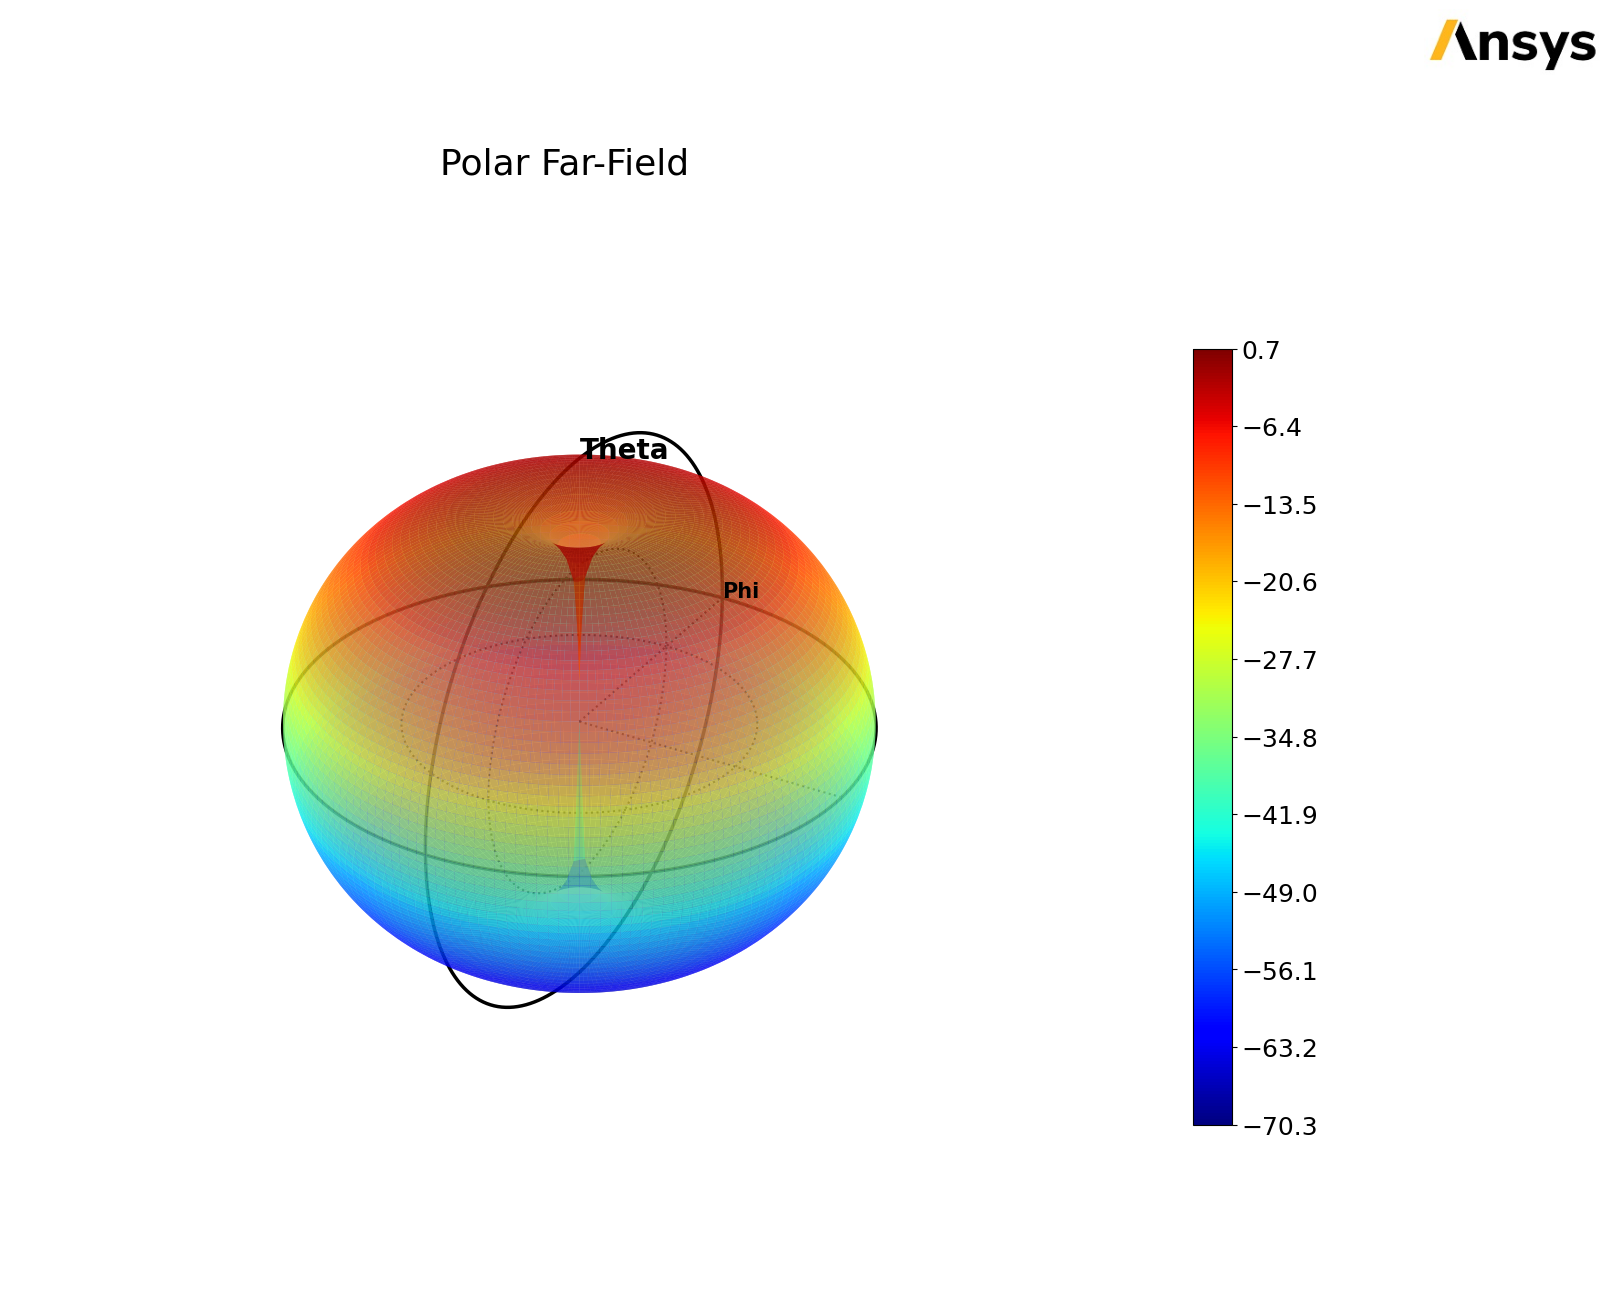

In [13]:
report_3d_data = report_3d.get_solution_data()
new_plot = report_3d_data.plot_3d()

### View cross-polarization

The dipole is linearly polarized as can be seen from the comparison of $\theta$-polarized
and $\phi$-polarized "realized gain" at $\theta=90^\circ$ degrees.
The following code creates the gain plots in AEDT.

In [14]:
xpol_expressions = ["db(RealizedGainTheta)", "db(RealizedGainPhi)"]
xpol = hfss.post.reports_by_category.far_field(["db(RealizedGainTheta)", "db(RealizedGainPhi)"],
                                                disc_sweep.name,
                                                name="Cross Polarization",
                                                sphere_name="Azimuth",
                                                Freq= [center_freq],)

xpol.report_type = "Radiation Pattern"
xpol.create(name="xpol")
xpol.children["Legend"].properties["Show Solution Name"] = False
xpol.children["Legend"].properties["Show Variation Key"] = False

PyAEDT WARNING: More than one sweep with name 'DiscreteSweep' found. Returning 'MySetup : DiscreteSweep'.


The ``get_solution_data()`` method is again used to create an inline plot of cross-polarization from
the report in HFSS.

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0060918331146240234
Time to initialize solution data:0.0060918331146240234


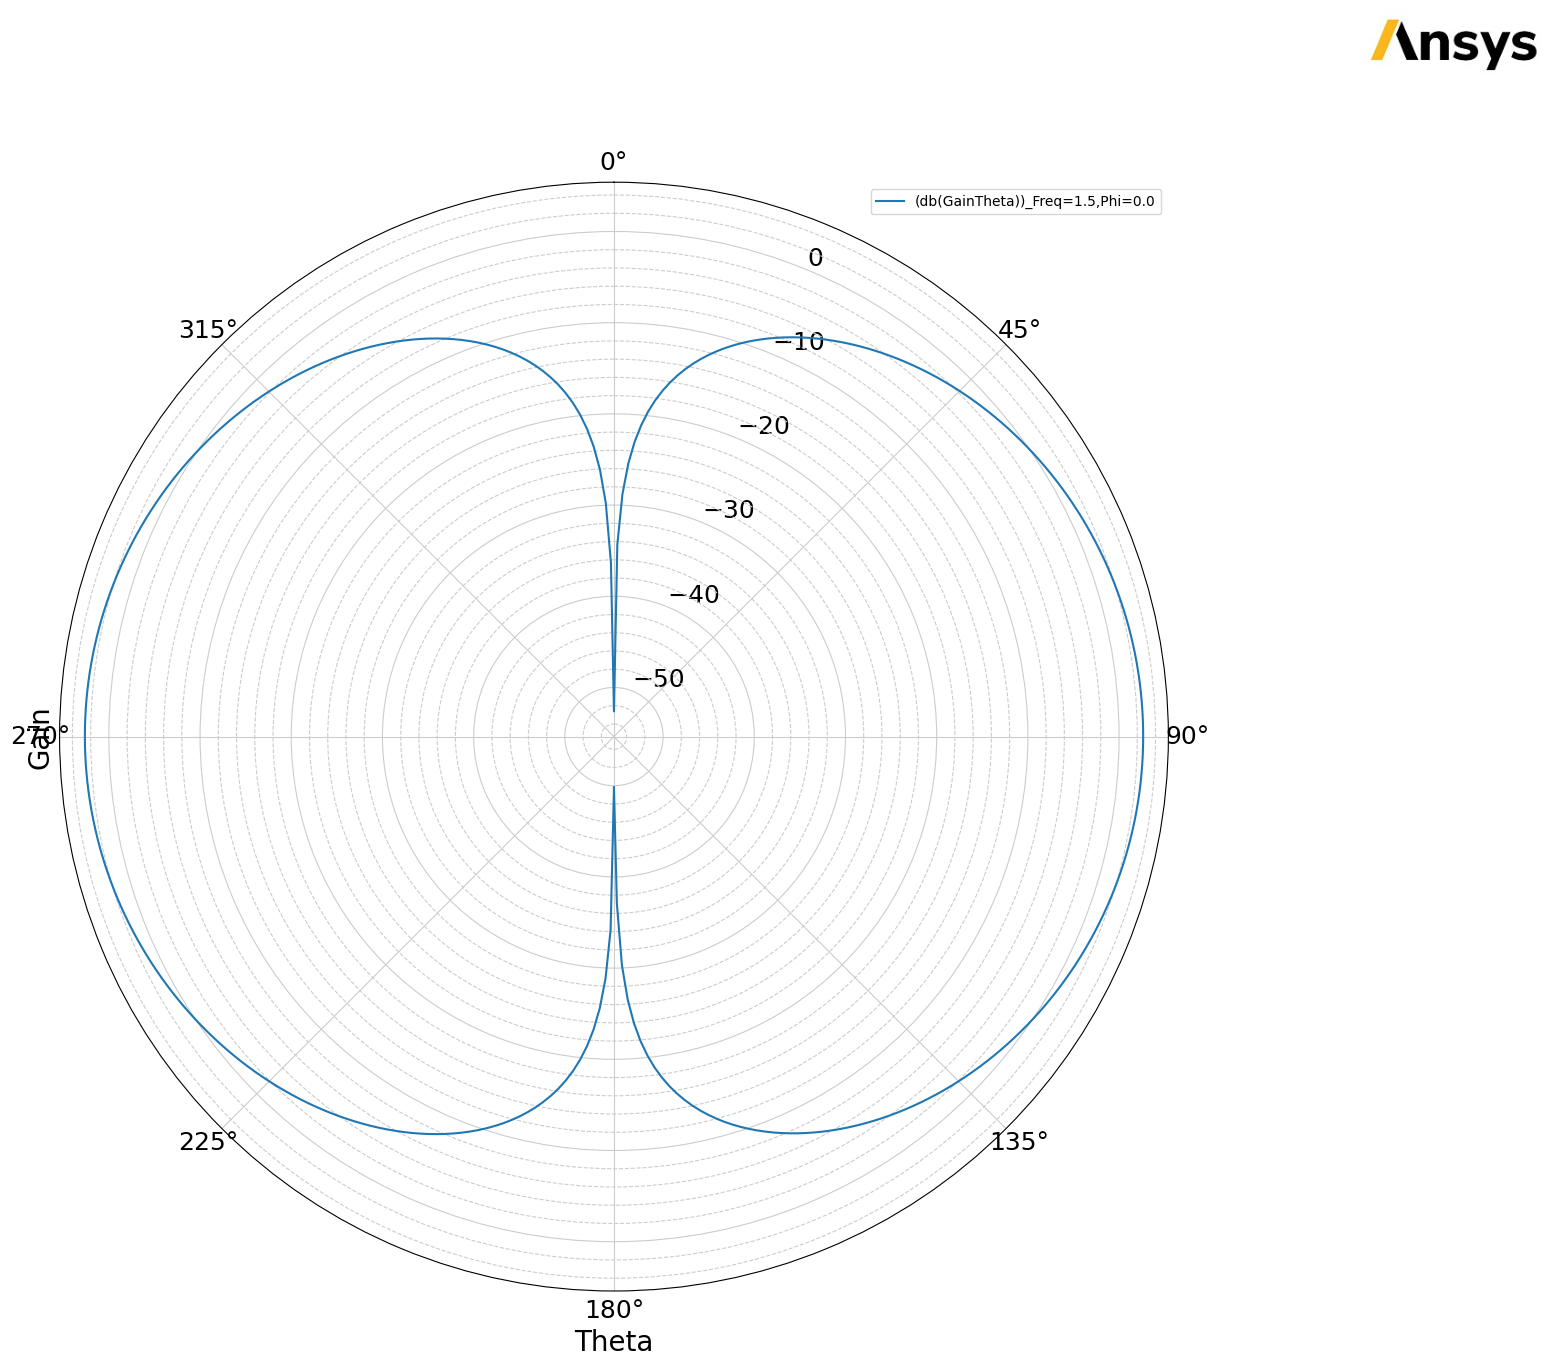

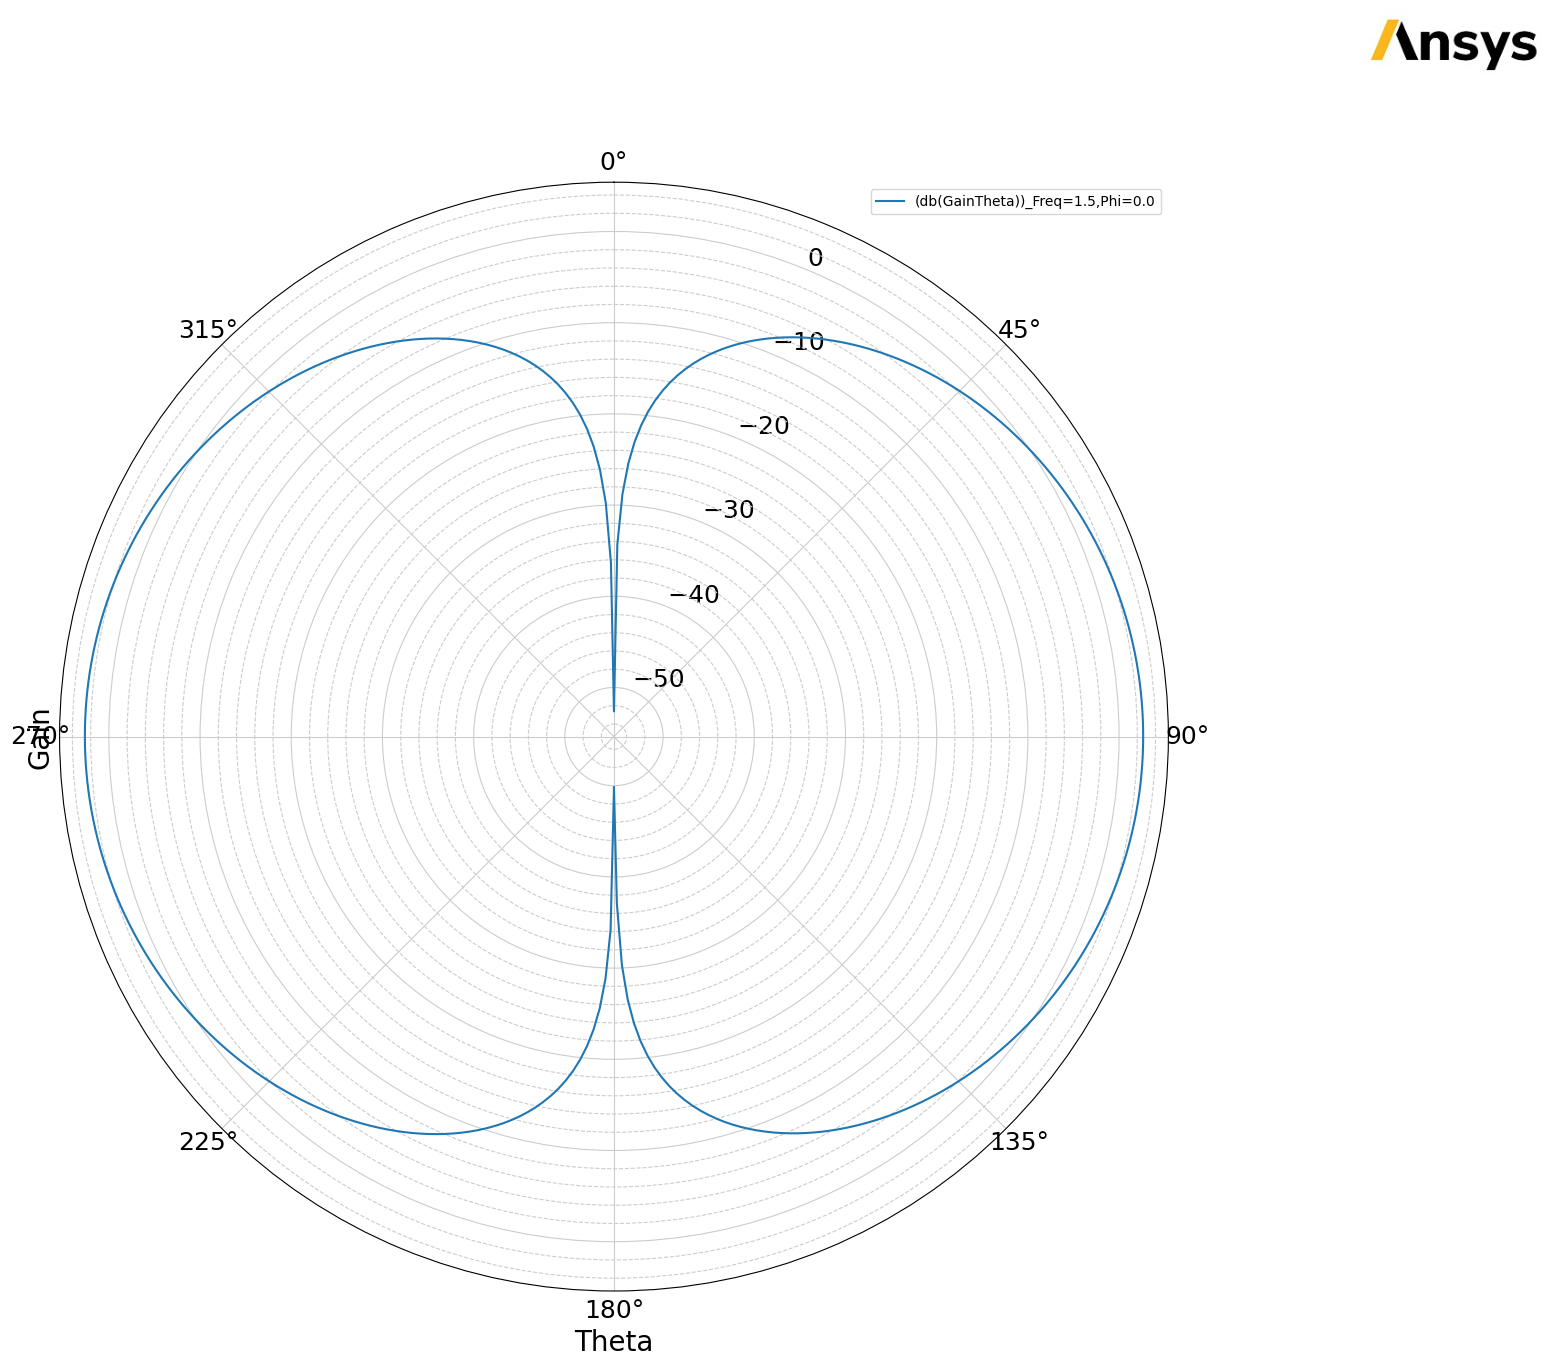

In [15]:
ff_el_data = elevation_ffd_plot.get_solution_data()
ff_el_data.plot(x_label="Theta", y_label="Gain", is_polar=True)

## Release AEDT

In [16]:
hfss.save_project()
hfss.release_desktop()

# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project dipole Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files.
The following cell removes all temporary files, including the project folder.

In [17]:
temp_folder.cleanup()